# **Modélisation LASSO**

**API SKL** : [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

**Guide SKL** : [**Lasso** (1.1.3)](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

**Résout** : $\min_{w} { \frac{1}{2n} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$

**Complexité** : $\mathcal{O}(p^3 + n p^2)$ ~ complexité OLS pour $p \ll n$ ([Source](https://stats.stackexchange.com/questions/76518/what-is-the-time-complexity-of-lasso-regression))


# Expérimentation

# Old à recycler

## [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso)

User Guide | [1.1.3. **Lasso**](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

### Chargement des données

In [ ]:
from seattle_commons import get_clean_ml_data
from pepper_skl_commons import Dataset

ml_data = get_clean_ml_data()

random_state = 42
test_size = .25
dataset = Dataset(ml_data, 'all', random_state, test_size)

X = dataset._X_train
Y = dataset.Y_train
targets = dataset.targets

from pepper_commons import print_title, print_subtitle, bold  # pretty print

best_alphas = dict()

✔ _data loaded
✔ struct loaded


#### Recherche en grille

Avec deux stratégies CV, KFold et ShuffleSplit

Recherche fine des coefficients optimaux

In [ ]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

# Expérimentation

## Config 1 : $e = f(a)$

Ensemble minimal.

$\{a : e\}$

Les performances sont sensiblement les mêmes que pour la régression.

$R^2_{1, \text{LASSO}}$ :
* $\mu = 0.34634385854040023$
* $\sigma = 0.15276616790305458$ 

$R^2_{1, \text{Ridge}}$ :
* $\mu = 0.19023369020621722$
* $\sigma = 0.34521894443183665$

$R^2_{1, \text{OLS}}$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [28]:
from seattle_commons import get_ml_data_cfg
config_name = "{a : e}"
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

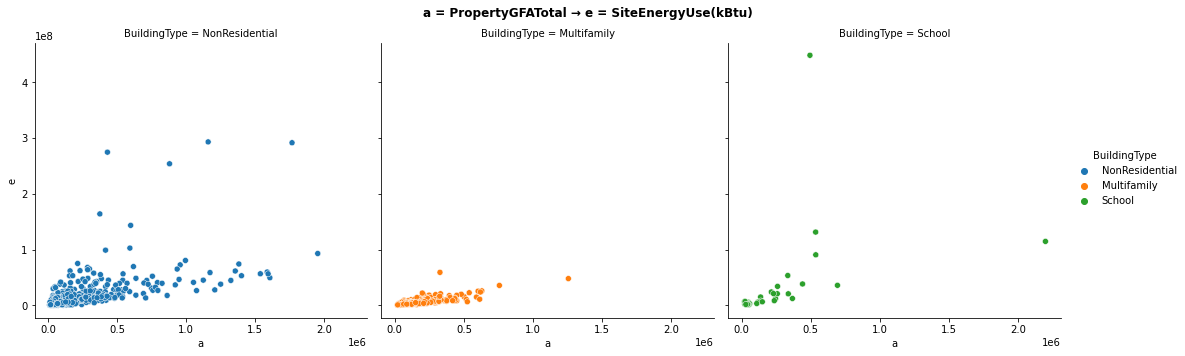

In [29]:
from seattle_commons import get_abstract_btype, plot_ml_data
btype = get_abstract_btype(data)   # hue labels
plot_ml_data(ml_data, btype=btype,
             x='a', y='e',
             title="a = PropertyGFATotal → e = SiteEnergyUse(kBtu)"
)

#### Vérifications

In [30]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [31]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection

Cette section est développée en étapes pour la première configuration, mais synthétisée dans la fonction `pepper_skl_commons.lasso_selection` appelée depuis les configuration suivantes.

In [32]:
from pepper_commons import print_title, print_subtitle, bold  # pretty print
import numpy as np
best_alphas = dict()
_y = np.ravel(y)


##### [Sélection de modèle Lasso à l'aide d'un critère d'information](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-an-information-criterion)

Estimation de l'hyperparamètre $\alpha$ cf. les deux critères d'information implémentés par SKL :
* **AIC** *Akaike Information Criterion*
* **BIC** *Bayes Information Criterion*

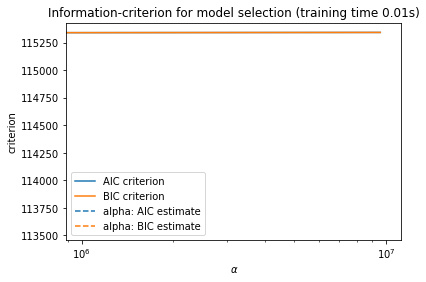

alpha: AIC estimate : 0.0
alpha: BIC estimate : 0.0
alpha: AIC / BIC mean estimate : 0.0


In [33]:
from pepper_skl_commons import lasso_best_from_ic
(
    _, best_alphas['aic'], best_alphas['bic'], _
    # _ ⇒ results, alpha_aic, alpha_bic, fit_time
) = lasso_best_from_ic(X, _y, show_tab=False, show_plot=True)
best_alphas['mic'] = (best_alphas['aic'] + best_alphas['bic']) / 2
print(bold('alpha: AIC / BIC mean estimate'), ':', best_alphas['mic'])

##### [Sélection de modèle Lasso par validation croisée : descente de coordonnées](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)

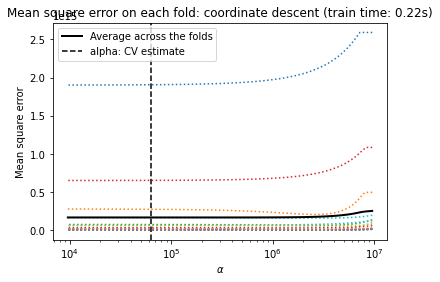

alpha: CD CV estimate : 63004.17852545276


In [34]:
from pepper_skl_commons import lasso_best_from_cd_cv
(
    best_alphas['cd_cv'], _, _, _, _
    # _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
) = lasso_best_from_cd_cv(X, _y, show_tab=False, show_plot=True)

##### [Sélection de modèle Lasso par validation croisée : régression du moindre angle](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)

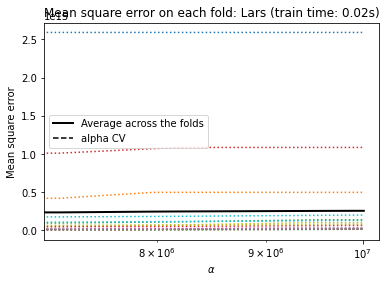

alpha: LARS VC estimate : 0.0


In [35]:
from pepper_skl_commons import lasso_best_from_lars_cv
(
    best_alphas['lars_cv'], _, _, _, _
    # _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
) = lasso_best_from_lars_cv(X, _y, show_tab=False, show_plot=True)

##### Synthèse

In [36]:
display(best_alphas)

{'aic': 0.0,
 'bic': 0.0,
 'mic': 0.0,
 'cd_cv': 63004.17852545276,
 'lars_cv': 0.0}

#### Lasso path using coordinate descent

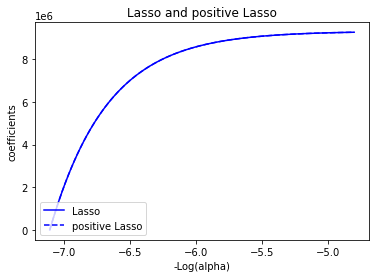

In [37]:
from pepper_skl_commons import plot_lasso_coordinate_descent_path
plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [38]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.2590294601579844


In [39]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Lasso
min_alpha_log = -5
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'positive': [True, False],
    'random_state': [42],
    'max_iter': [100_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

c:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.399e+16, tolerance: 1.502e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+16, tolerance: 1.693e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.539e+16, toleranc

In [40]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=10.0, max_iter=100000, positive=True, random_state=42)
best params : {'alpha': 10.0, 'max_iter': 100000, 'positive': True, 'random_state': 42}
best score : 0.25902946016483286
best index : 198

Scores
    train score : 0.51352762451025
     test score : 0.31189034226392864
3-CV mean score : 0.3461247247323118
 3-CV std score : 0.15269194519932527


In [41]:
from pepper_skl_commons import select_important_features
features = select_important_features(best_estimator, eps=0)
display(features)

There are 1 important features


,coef
__const__,-1.438528e+06
a,7.015004e+01


In [42]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_positive,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.002201,0.000400,0.001799,0.000400,10.0,100000,False,42,"{'alpha': 10.0, 'max_iter': 100000, 'positive'...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,1
198,0.002401,0.000490,0.001200,0.000400,10.0,100000,True,42,"{'alpha': 10.0, 'max_iter': 100000, 'positive'...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,1
196,0.001999,0.000001,0.001800,0.000400,8.69749,100000,True,42,"{'alpha': 8.697490026177835, 'max_iter': 10000...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,3
197,0.002200,0.000400,0.001800,0.000400,8.69749,100000,False,42,"{'alpha': 8.697490026177835, 'max_iter': 10000...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,3
194,0.002193,0.000403,0.001200,0.000400,7.564633,100000,True,42,"{'alpha': 7.56463327554629, 'max_iter': 100000...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0.046399,0.035458,0.001800,0.000400,0.000163,100000,True,42,"{'alpha': 0.00016297508346206434, 'max_iter': ...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,191
41,0.047999,0.036761,0.001601,0.000491,0.000163,100000,False,42,"{'alpha': 0.00016297508346206434, 'max_iter': ...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,191
42,0.050000,0.038996,0.002000,0.000001,0.000187,100000,True,42,"{'alpha': 0.0001873817422860383, 'max_iter': 1...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,191
43,0.047201,0.036504,0.001800,0.000400,0.000187,100000,False,42,"{'alpha': 0.0001873817422860383, 'max_iter': 1...",0.455879,0.407818,-0.035561,0.051842,0.415168,0.259029,0.207353,191


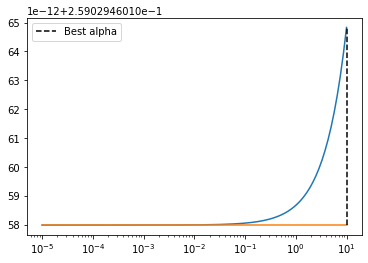

In [43]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log)

##### Recherche en grille intégrée

best alpha : 1609153561.295315
best score : 0.5135271109826256
    train score : 0.5135271109826256
     test score : 0.31200765844575973
3-CV mean score : 0.34634385854040023
 3-CV std score : 0.15276616790305458


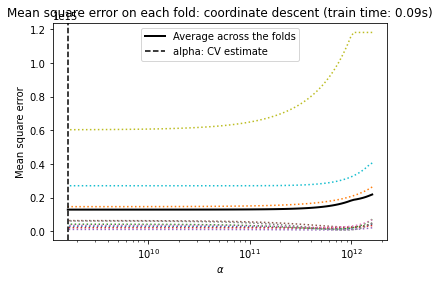

In [44]:
from pepper_skl_commons import builtin_best_lasso_cv_search
builtin_best_lasso_cv_search(Xy, X, y)

## Config 9 : $\ln{e} = f(\ln{a}, n_\star)$

Contribution du score ENERGYSTAR.

$\{n_\star, \log(a) :\log(e)\}$

Amélioration négligeable.

$R^2_{9, \text{LASSO}}$:
* $\mu = 0.6166563538370583$
* $\sigma = 0.05979515734612156$

$R^2_{9, \text{Ridge}}$:
* $\mu = 0.6166516138510613$
* $\sigma = 0.0599534988115941$

$R^2_{9, \text{OLS}}$:
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

$R^2_{\text{OLS}, 4} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [15]:
config_name = "{n_★, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

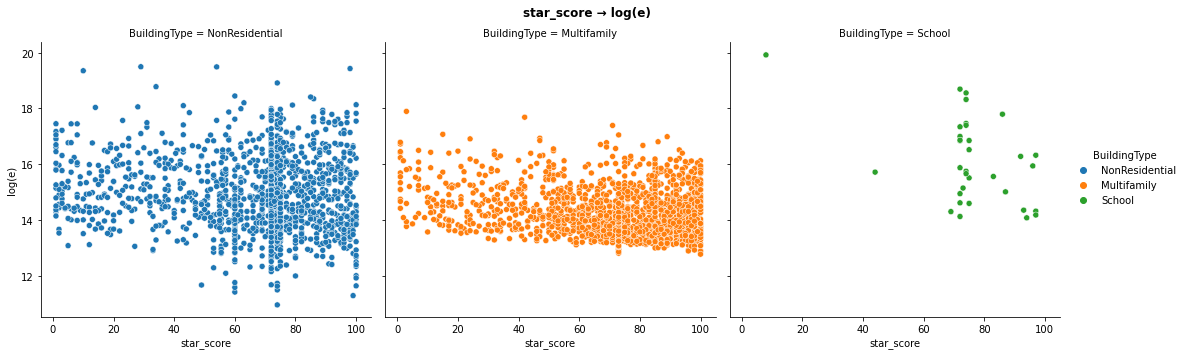

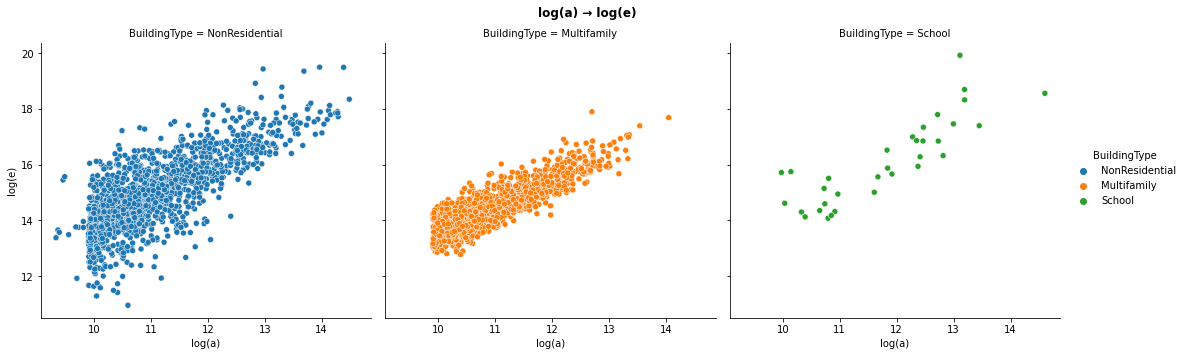

In [16]:
# title="star_score = ENERGYSTARScore → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [17]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [18]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection


Lasso IC selection


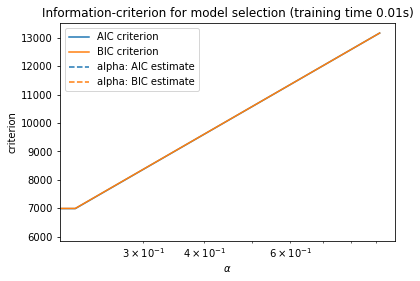

alpha: AIC estimate : 0.0
alpha: BIC estimate : 0.0
alpha: AIC / BIC mean estimate : 0.0

Lasso CD CV selection


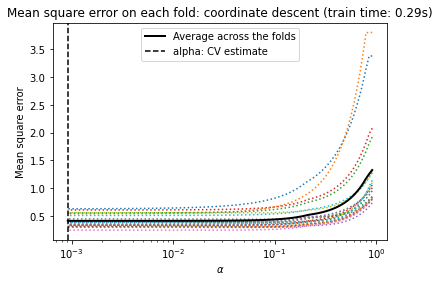

alpha: CD CV estimate : 0.0009163905498710741

Lasso LARS CV selection


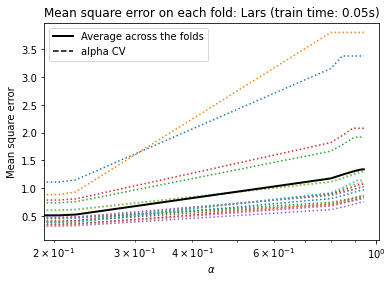

alpha: LARS VC estimate : 0.0

Synthesis


{'aic': 0.0,
 'bic': 0.0,
 'mic': 0.0,
 'cd_cv': 0.0009163905498710741,
 'lars_cv': 0.0}

alpha: mean estimate : 0.0003054635166236914


In [19]:
from pepper_skl_commons import lasso_selection
_ = lasso_selection(X, y)

#### Lasso path using coordinate descent

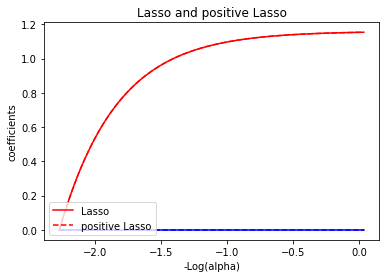

In [20]:
from pepper_skl_commons import plot_lasso_coordinate_descent_path
plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [21]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.6971301496397384


In [22]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Lasso
min_alpha_log = -5
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'positive': [True, False],
    'random_state': [42],
    'max_iter': [100_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [23]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=0.006135907273413176, max_iter=100000, random_state=42)
best params : {'alpha': 0.006135907273413176, 'max_iter': 100000, 'positive': False, 'random_state': 42}
best score : 0.697175907571976
best index : 93

Scores
    train score : 0.7062291136011234
     test score : 0.6784833957465781
3-CV mean score : 0.616076531978844
 3-CV std score : 0.058378371992854304


In [24]:
from pepper_skl_commons import select_important_features
features = select_important_features(best_estimator, eps=0)
display(features)

There are 2 important features


,coef
__const__,3.666406
star_score,-0.008585
log(a),1.052942


In [25]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_positive,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
93,0.002383,0.000492,0.001011,0.000022,0.006136,100000,False,42,"{'alpha': 0.006135907273413176, 'max_iter': 10...",0.661477,0.677881,0.666722,0.729925,0.749874,0.697176,0.035844,1
95,0.002211,0.000396,0.001009,0.000021,0.007055,100000,False,42,"{'alpha': 0.007054802310718645, 'max_iter': 10...",0.661524,0.677977,0.666764,0.729956,0.749656,0.697176,0.035758,2
91,0.002192,0.000409,0.001402,0.000507,0.005337,100000,False,42,"{'alpha': 0.005336699231206312, 'max_iter': 10...",0.661434,0.677796,0.666683,0.729897,0.750063,0.697175,0.035918,3
97,0.002003,0.000002,0.001592,0.000498,0.008111,100000,False,42,"{'alpha': 0.008111308307896872, 'max_iter': 10...",0.661577,0.678085,0.666811,0.729988,0.749403,0.697173,0.035660,4
89,0.002001,0.000021,0.001798,0.000420,0.004642,100000,False,42,"{'alpha': 0.004641588833612782, 'max_iter': 10...",0.661396,0.677721,0.666649,0.729871,0.750226,0.697173,0.035983,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.002414,0.000491,0.001385,0.000485,1.232847,100000,True,42,"{'alpha': 1.232846739442066, 'max_iter': 10000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,176
166,0.001993,0.000632,0.001808,0.000404,1.072267,100000,True,42,"{'alpha': 1.072267222010323, 'max_iter': 10000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,176
164,0.001995,0.000014,0.001608,0.000484,0.932603,100000,True,42,"{'alpha': 0.9326033468832199, 'max_iter': 1000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,176
186,0.002017,0.000017,0.000983,0.000016,4.328761,100000,True,42,"{'alpha': 4.328761281083062, 'max_iter': 10000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,176


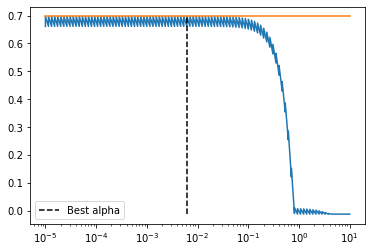

In [26]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log)

##### Recherche en grille intégrée

best alpha : 0.0039320896509135814
best score : 0.7062532678951778
    train score : 0.7062532678951778
     test score : 0.6785465835125756
3-CV mean score : 0.6166563538370583
 3-CV std score : 0.05979515734612156


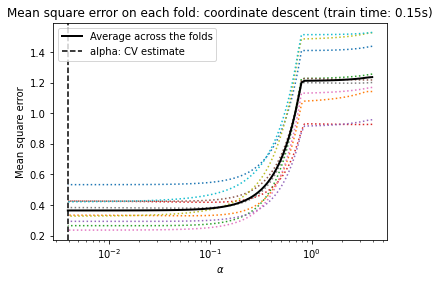

In [27]:
from pepper_skl_commons import builtin_best_lasso_cv_search
builtin_best_lasso_cv_search(Xy, X, y)

## Config 15 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration.

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}$

Le LASSO sous-performe légèrement (-0.003) par rapport au Ridge.

$R^2_{15, \text{LASSO}}$ :
* $\mu = 0.785052627954466$
* $\sigma = 0.037645015872033144$ 

$R^2_{15, \text{Ridge}}$ :
* $\mu = 0.7882594503864948$
* $\sigma = 0.03660944556470606$

$R^2_{15, \text{OLS}}$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [46]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [47]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Retail Store,ptype_Hotel,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,62.0,2.197225,11.974620,15.488496
43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,8.0,1.386294,13.111980,19.921163
100,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,96.0,1.791759,12.664465,16.439886
234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.825601,12.972641
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,73.0,1.098612,11.420042,16.063888
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,55.5,1.098612,12.096040,16.060086
248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.979172,15.183818
264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,75.0,1.609438,11.615347,16.172386
265,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,85.0,2.079442,11.669476,16.122100


✔ No NA coefficient


#### Partition

In [48]:
from seattle_commons import features_target_split
from sklearn.model_selection import train_test_split

# Features / target split
X, y = features_target_split(ml_data)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection


Lasso IC selection


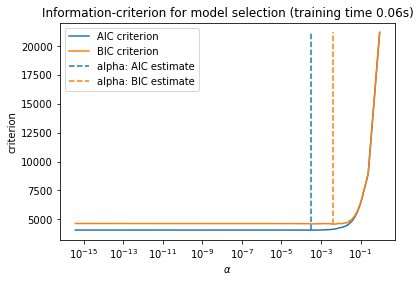

alpha: AIC estimate : 0.00031501941662773816
alpha: BIC estimate : 0.0041908970157252855
alpha: AIC / BIC mean estimate : 0.002252958216176512

Lasso CD CV selection


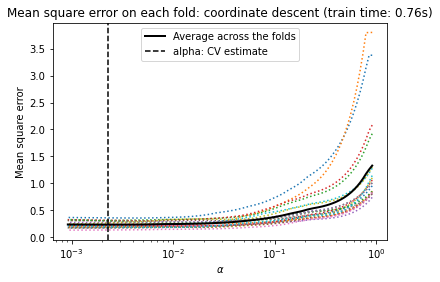

alpha: CD CV estimate : 0.002269969363939881

Lasso LARS CV selection


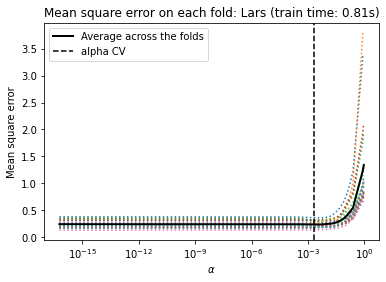

alpha: LARS VC estimate : 0.0021817422844033255

Synthesis


{'aic': 0.00031501941662773816,
 'bic': 0.0041908970157252855,
 'mic': 0.002252958216176512,
 'cd_cv': 0.002269969363939881,
 'lars_cv': 0.0021817422844033255}

alpha: mean estimate : 0.002234889954839906


In [49]:
from pepper_skl_commons import lasso_selection
_ = lasso_selection(X, y)

#### Lasso path using coordinate descent

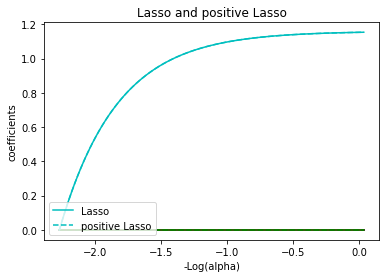

In [50]:
from pepper_skl_commons import plot_lasso_coordinate_descent_path
plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [51]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.03509943465204464


In [52]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Lasso
min_alpha_log = -5
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'positive': [True, False],
    'random_state': [42],
    'max_iter': [100_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [53]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=0.0013219411484660286, max_iter=100000, random_state=42)
best params : {'alpha': 0.0013219411484660286, 'max_iter': 100000, 'positive': False, 'random_state': 42}
best score : 0.799140660996049
best index : 71

Scores
    train score : 0.8344405765673579
     test score : 0.792439104584342
3-CV mean score : 0.7787315526489814
 3-CV std score : 0.032816264154596764


In [54]:
from pepper_skl_commons import select_important_features
features = select_important_features(best_estimator, eps=0)
display(features)

There are 30 important features


,coef
__const__,4.504315
ptype_Low-Rise Multifamily,-0.480627
ptype_Mid-Rise Multifamily,-0.354969
ptype_Small- and Mid-Sized Office,-0.048523
ptype_Other,0.228105
ptype_Mixed Use Property,-0.101850
ptype_High-Rise Multifamily,-0.241100
ptype_Hotel,0.212944
ptype_Worship Facility,-0.272284
ptype_Distribution Center,-0.728609


In [12]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_positive,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
71,0.009083,0.001366,0.003546,0.001420,0.001322,100000,False,42,"{'alpha': 0.0013219411484660286, 'max_iter': 1...",0.781183,0.777896,0.811876,0.827302,0.797447,0.799141,0.018611,1
73,0.010940,0.001965,0.004005,0.000643,0.00152,100000,False,42,"{'alpha': 0.0015199110829529332, 'max_iter': 1...",0.780880,0.779665,0.809034,0.826593,0.799392,0.799113,0.017688,2
69,0.006598,0.000503,0.002974,0.000874,0.00115,100000,False,42,"{'alpha': 0.0011497569953977356, 'max_iter': 1...",0.781505,0.776166,0.813514,0.827722,0.794861,0.798754,0.019390,3
75,0.012182,0.002214,0.004006,0.000621,0.001748,100000,False,42,"{'alpha': 0.0017475284000076847, 'max_iter': 1...",0.780466,0.781278,0.805207,0.825674,0.799622,0.798449,0.016772,4
67,0.008601,0.001960,0.003200,0.000978,0.001,100000,False,42,"{'alpha': 0.001, 'max_iter': 100000, 'positive...",0.781963,0.774168,0.814540,0.827455,0.792137,0.798052,0.020004,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.005049,0.000867,0.003403,0.001019,1.629751,100000,True,42,"{'alpha': 1.6297508346206435, 'max_iter': 1000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,181
164,0.007509,0.000904,0.004400,0.001021,0.932603,100000,True,42,"{'alpha': 0.9326033468832199, 'max_iter': 1000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,181
170,0.005997,0.001263,0.003999,0.000895,1.417474,100000,True,42,"{'alpha': 1.4174741629268048, 'max_iter': 1000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,181
186,0.004793,0.001171,0.003605,0.000482,4.328761,100000,True,42,"{'alpha': 4.328761281083062, 'max_iter': 10000...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,181


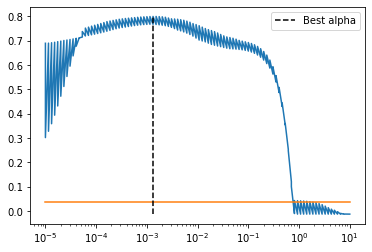

In [12]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log)

##### Recherche en grille intégrée

best alpha : 0.007002302649417211
best score : 0.7955609218401737
    train score : 0.7955609218401737
     test score : 0.7596958930901934
3-CV mean score : 0.785052627954466
 3-CV std score : 0.037645015872033144


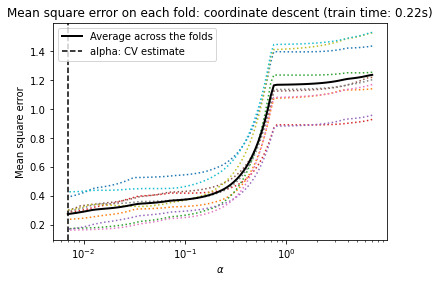

In [14]:
from pepper_skl_commons import builtin_best_lasso_cv_search
builtin_best_lasso_cv_search(Xy, X, y)

## Config 16 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration avec sélection et retrait de variables non pertinentes.

$\{t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}$

<mark>A revoir : Les performances s'effondrent : conclusion : le fait qu'un coefficient soit nul ou non n'implique rien quant à son importance.</mark>



$R^2_{16} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [58]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name)
ml_data = ml_data[list(features.index)[1:]]
display(ml_data)

,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Hotel,ptype_Worship Facility,ptype_Distribution Center,ptype_Medical Office,...,_ua_Hospital (General Medical & Surgical),_ua_Other - Entertainment/Public Assembly,_ua_Distribution Center,_ua_Supermarket/Grocery Store,_ua_Other - Recreation,_ua_Restaurant,_ua_Museum,star_score,log(n_l),log(a)
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,60.0,2.564949,11.390012
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.044629,0.0,61.0,2.484907,11.547964
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,43.0,3.737670,13.770628
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,56.0,2.397895,11.023861
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,75.0,2.944439,12.075850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,72.0,0.693147,9.812523
50223,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,72.0,0.693147,9.680344
50224,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.576347,0.000000,0.0,72.0,0.693147,9.484709


#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [59]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Hotel,ptype_Worship Facility,ptype_Distribution Center,ptype_Medical Office,...,_ua_Hospital (General Medical & Surgical),_ua_Other - Entertainment/Public Assembly,_ua_Distribution Center,_ua_Supermarket/Grocery Store,_ua_Other - Recreation,_ua_Restaurant,_ua_Museum,star_score,log(n_l),log(a)
id,,,,,,,,,,,,,,,,,,,,,
354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-0.000307,0.0,93.0,3.637586,13.866649
432,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-0.281042,0.0,75.0,2.397895,12.462639
525,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.774699,0.0,0.000000,0.407998,-0.058878,0.0,75.0,1.945910,11.948984
601,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-0.455775,0.0,75.0,1.098612,10.878085
657,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,-0.133931,0.000000,-0.133931,0.0,31.0,0.000000,13.154650
772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-0.017773,0.0,95.0,3.761200,14.037898
804,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-1.062644,0.0,72.0,1.791759,12.622329
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,60.0,0.693147,11.086564
20163,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,-0.018804,0.0,90.0,3.637586,13.156115


✔ No NA coefficient


#### Partition

In [60]:
from seattle_commons import features_target_split
from sklearn.model_selection import train_test_split

# Features / target split
X, y = features_target_split(ml_data)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection


Lasso IC selection


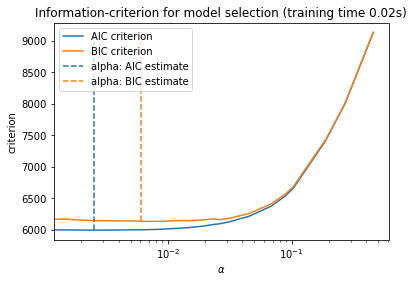

alpha: AIC estimate : 0.0025256211044551204
alpha: BIC estimate : 0.0060890949618782495
alpha: AIC / BIC mean estimate : 0.004307358033166685

Lasso CD CV selection


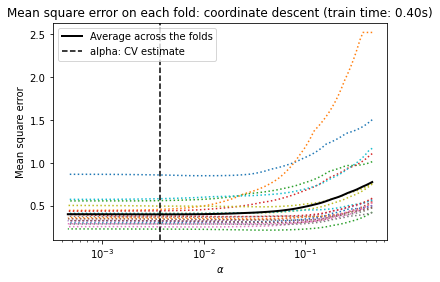

alpha: CD CV estimate : 0.003696202223713655

Lasso LARS CV selection


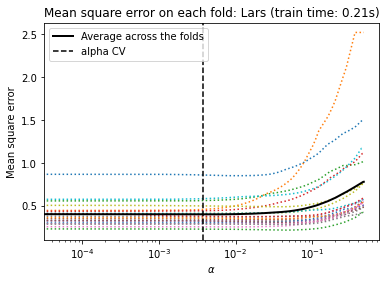

alpha: LARS VC estimate : 0.003754768827000338

Synthesis


{'aic': 0.0025256211044551204,
 'bic': 0.0060890949618782495,
 'mic': 0.004307358033166685,
 'cd_cv': 0.003696202223713655,
 'lars_cv': 0.003754768827000338}

alpha: mean estimate : 0.003919443027960226


In [61]:
from pepper_skl_commons import lasso_selection
_ = lasso_selection(X, y)

#### Lasso path using coordinate descent

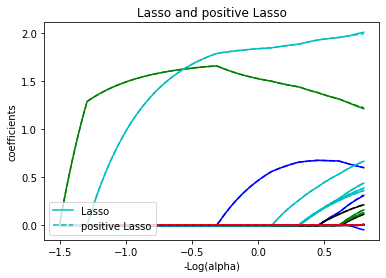

In [62]:
from pepper_skl_commons import plot_lasso_coordinate_descent_path
plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [63]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.5278324502258412


In [64]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Lasso
min_alpha_log = -5
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'positive': [True, False],
    'random_state': [42],
    'max_iter': [100_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [65]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=0.002009233002565048, max_iter=100000, random_state=42)
best params : {'alpha': 0.002009233002565048, 'max_iter': 100000, 'positive': False, 'random_state': 42}
best score : 0.561551139400058
best index : 77

Scores
    train score : 0.5893837336067471
     test score : 0.44210160999159775
3-CV mean score : 0.28352913889956155
 3-CV std score : 0.06763278211187235


In [66]:
from pepper_skl_commons import select_important_features
features = select_important_features(best_estimator, eps=0)
display(features)

There are 18 important features


,coef
__const__,9.930878
ptype_Low-Rise Multifamily,-0.298035
ptype_Mid-Rise Multifamily,-0.122688
ptype_Small- and Mid-Sized Office,-0.545906
ptype_Other,-0.025045
ptype_Mixed Use Property,-0.017905
ptype_High-Rise Multifamily,0.040993
ptype_Hotel,-0.055980
ptype_Worship Facility,-0.393033
ptype_Medical Office,-0.050369


In [67]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_positive,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
77,0.004801,0.000979,0.002598,0.000490,0.002009,100000,False,42,"{'alpha': 0.002009233002565048, 'max_iter': 10...",0.545795,0.546128,0.586084,0.534390,0.595359,0.561551,0.024367,1
79,0.004203,0.000754,0.002601,0.000800,0.00231,100000,False,42,"{'alpha': 0.0023101297000831605, 'max_iter': 1...",0.543247,0.546337,0.586318,0.534969,0.594657,0.561106,0.024419,2
75,0.004203,0.000749,0.002797,0.000977,0.001748,100000,False,42,"{'alpha': 0.0017475284000076847, 'max_iter': 1...",0.548276,0.546225,0.585918,0.533786,0.590540,0.560949,0.022866,3
73,0.004403,0.000492,0.002397,0.000473,0.00152,100000,False,42,"{'alpha': 0.0015199110829529332, 'max_iter': 1...",0.550827,0.546488,0.585591,0.533689,0.582060,0.559731,0.020495,4
81,0.005215,0.001614,0.002992,0.000880,0.002656,100000,False,42,"{'alpha': 0.0026560877829466868, 'max_iter': 1...",0.540252,0.546433,0.586565,0.535709,0.586287,0.559049,0.022611,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.003401,0.000489,0.002400,0.000801,0.613591,100000,True,42,"{'alpha': 0.6135907273413176, 'max_iter': 1000...",-0.006728,-0.009010,-0.001323,-0.015833,-0.002686,-0.007116,0.005156,196
156,0.004598,0.001022,0.002401,0.000492,0.53367,100000,True,42,"{'alpha': 0.5336699231206312, 'max_iter': 1000...",-0.007335,-0.009010,-0.001323,-0.016068,-0.003113,-0.007370,0.005158,197
150,0.003800,0.000979,0.002600,0.000490,0.351119,100000,True,42,"{'alpha': 0.35111917342151344, 'max_iter': 100...",-0.008908,-0.007046,-0.000506,-0.016700,-0.004183,-0.007469,0.005417,198
154,0.003601,0.000800,0.002200,0.000400,0.464159,100000,True,42,"{'alpha': 0.4641588833612782, 'max_iter': 1000...",-0.007904,-0.008381,-0.001323,-0.016293,-0.003505,-0.007481,0.005145,199


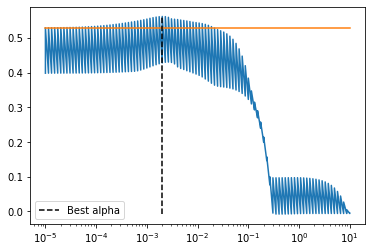

In [68]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log)

##### Recherche en grille intégrée

best alpha : 0.009310566743364553
best score : 0.5570436198950071
    train score : 0.5570436198950071
     test score : 0.4225383472819537
3-CV mean score : 0.2899238627442567
 3-CV std score : 0.07316457501472035


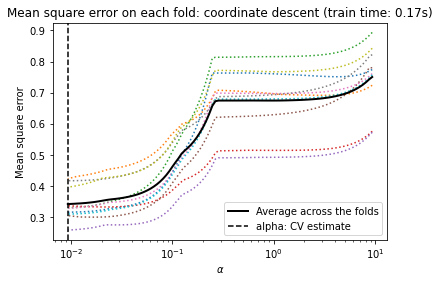

In [69]:
from pepper_skl_commons import builtin_best_lasso_cv_search
builtin_best_lasso_cv_search(Xy, X, y)